In [8]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot

In [2]:
data = np.load("../data/11-01_mapped.npy")

#### We have 1 datapoint per 10 minutes, resulting in 144 data points per day

In [21]:
data.shape

(100, 100)


In [49]:
def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

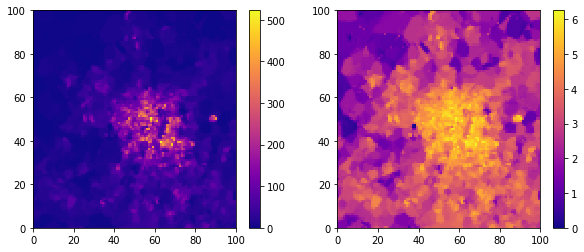

In [98]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
dots1 = data[40]
plt.pcolormesh(dots1, cmap='plasma', vmin=dots1.min(), vmax=dots1.max())
plt.colorbar()

plt.subplot(1, 2, 2)
dots2 = np.log(data[40] + 1)
plt.pcolormesh(dots2, cmap='plasma', vmin=dots2.min(), vmax=dots2.max())
plt.colorbar()

# plt.subplots_adjust(wspace=0.5)

plt.show()
